신경망이 지니고 있는 단점인 과적합과 Gradient Vanishing을 완화할 수 있는 여러 알고리즘이 나오면서 딥러닝이 발전하게 되었다.

딥러닝 모델 디자인 요소 : Hidden Layer, Hidden 노드의 수, Activation 함수, Initialization 기법, Optimizer

### 사람의 손글씨 데이터인 MNIST를 이용해 Multi Layer Perceptron(MLP) 설계할 때 Dropout 적용해보기

Dropout : 신경망의 학습 과정 중 weight matrix에 랜덤하게 일부 column에 0을 집어넣어 연산. epoch마다 랜덤하게 dropout

In [ ]:
# module import
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [ ]:
# 장비 확인
if torch.cuda.is_available():
  DEVICE=torch.device('cuda')
else:
  DEVICE=torch.device('cpu')

In [ ]:
BATCH_SIZE=32 # 32개의 데이터로 1개의 mini-batch를 구성, iteration : 1개의 mini-batch를 이용해 학습하는 횟수
EPOCHS=10 # 전체 데이터를 이용해 학습을 진행한 횟수

In [ ]:
# MNIST 데이터 다운로드
train_dataset=datasets.MNIST(root="../data/MNIST", train=True, download=True, transform=transforms.ToTensor())
test_dataset=datasets.MNIST(root="../data/MNIST", train=False, transform=transforms.ToTensor())
train_loader=torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# 데이터 확인하기(1)
for (X_train, y_train) in train_loader:
  print('X_train:', X_train.size(), 'type:', X_train.type()) # 32개의 이미지 데이터가 1개의 mini-batch 구성. 가로 28개, 세로 28개, 채널 1 = 흑백으로 이루어진 데이터
  print('y_train:', y_train.size(), 'type:', y_train.type()) # 32개의 이미지 데이터에 각각 label 값이 1개씩 존재
  break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


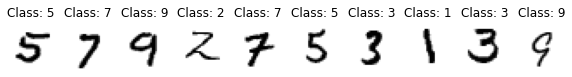

In [ ]:
# 데이터 확인하기(2)
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.axis('off')
  plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
  plt.title('Class: '+str(y_train[i].item()))

In [ ]:
# MLP 모델 설계
class Net(nn.Module): # 딥러닝 모델 관련 기본 함수를 포함하고 있는 nn.Module 클래스를 상속받는 Net 클래스 정의
  def __init__(self):
    super(Net, self).__init__()
    # fully connected layer 정의
    self.fc1=nn.Linear(28*28, 512) 
    self.fc2=nn.Linear(512, 256)
    self.fc3=nn.Linear(256, 10) # label 개수와 동일하게 설정 (원-핫 인코딩) 
    self.dropout_prob=0.5 # 몇 퍼센트의 노드에 대해 가중값을 계산하지 않을 것인지를 명시
  def forward(self, x):
    x=x.view(-1, 28*28) # view 메서드 이용하여 flatten
    x=self.fc1(x)
    x=F.sigmoid(x)
    # 마지막에 output(y값) 구하기 전에 dropout
    x=F.dropout(x, training=self.training, p=self.dropout_prob) # 평가 과정 속에서는 모든 노드를 이용해 output을 계산하기 때문에 학습 상태와 검증 상태에서 다르게 적용하기 위한 파라미터
    x=self.fc2(x)
    x=F.sigmoid(x)
    x=F.dropout(x, training=self.training, p=self.dropout_prob)
    x=self.fc3(x)
    x=F.log_softmax(x, dim=1) # softmax 이용해 확률 계산
    return x

In [ ]:
# Optimizer, Objective Function 설정
model=Net().to(DEVICE)
optimizer=torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5) # SGD : 데이터를 조개서 Gradient Descent Method , Optimizer : 이렇게 Gradient Descent해주는 것을 통틀어
criterion=nn.CrossEntropyLoss() # 원-핫 인코딩 값 계산 위해

In [ ]:
# MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader): # train_loader에는 학습에 이용되는 이미지 데이터와 레이블 데이터가 mini-batch 단위로 묶여서 저장되어있음
    image=image.to(DEVICE)
    label=label.to(DEVICE)
    optimizer.zero_grad() # optimizer 초기화
    output=model(image)
    loss=criterion(output, label)
    loss.backward()
    optimizer.step()

    if batch_idx%log_interval==0:
      print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(Epoch, batch_idx*len(image), len(train_loader.dataset), 100.*batch_idx/len(train_loader), loss.item()))

In [ ]:
# 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
  model.eval()
  test_loss=0
  correct=0

  with torch.no_grad():
    for image, label in test_loader:
      image=image.to(DEVICE)
      label=label.to(DEVICE)
      output=model(image)
      test_loss+=criterion(output, label).item()
      prediction=output.max(1, keepdim=True)[1] # 계산된 벡터 값 내 가장 큰 값인 위치에 대해 해당 위치에 대응하는 클래스로 예측했다고 판단
      correct+=prediction.eq(label.view_as(prediction)).sum().item()
  
  test_loss/=len(test_loader.dataset)
  test_accuracy=100. *correct/len(test_loader.dataset)
  return test_loss, test_accuracy

In [ ]:
# MLP 학습을 실행하면서 Train, Test set의 Loss 및 Test set Accuracy를 확인하기
for Epoch in range(1, EPOCHS+1):
  train(model, train_loader, optimizer, log_interval=200)
  test_loss, test_accuracy=evaluate(model, test_loader)
  print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".format(Epoch, test_loss, test_accuracy))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000(0%)]	Train Loss: 2.505495
Train Epoch: 1 [6400/60000(11%)]	Train Loss: 2.320647
Train Epoch: 1 [12800/60000(21%)]	Train Loss: 2.360442
Train Epoch: 1 [19200/60000(32%)]	Train Loss: 2.359309
Train Epoch: 1 [25600/60000(43%)]	Train Loss: 2.332768
Train Epoch: 1 [32000/60000(53%)]	Train Loss: 2.310847
Train Epoch: 1 [38400/60000(64%)]	Train Loss: 2.332471
Train Epoch: 1 [44800/60000(75%)]	Train Loss: 2.314453
Train Epoch: 1 [51200/60000(85%)]	Train Loss: 2.335973
Train Epoch: 1 [57600/60000(96%)]	Train Loss: 2.258780

[EPOCH: 1], 	Test Loss: 0.0713, 	Test Accuracy: 24.68 %

Train Epoch: 2 [0/60000(0%)]	Train Loss: 2.288188
Train Epoch: 2 [6400/60000(11%)]	Train Loss: 2.254371
Train Epoch: 2 [12800/60000(21%)]	Train Loss: 2.338326
Train Epoch: 2 [19200/60000(32%)]	Train Loss: 2.288421
Train Epoch: 2 [25600/60000(43%)]	Train Loss: 2.197824
Train Epoch: 2 [32000/60000(53%)]	Train Loss: 2.180746
Train Epoch: 2 [38400/60000(64%)]	Train Loss: 2.282663
Train Epoch: 2 [448

### 사람의 손글씨 데이터인 MNIST를 이용해 Multi Layer Perceptron(MLP) 설계할 때 Dropout+ReLu 적용해보기
ReLu : 0 미만인 값은 0으로 계산하고 양수 값은 그대로 반영하는 비선형 함수. 기울기가 0 또는 1이 되기 때문에 gradient 빠르게 계산 가능.

In [24]:
# MLP 모델 설계
class Net(nn.Module): # 딥러닝 모델 관련 기본 함수를 포함하고 있는 nn.Module 클래스를 상속받는 Net 클래스 정의
  def __init__(self):
    super(Net, self).__init__()
    # fully connected layer 정의
    self.fc1=nn.Linear(28*28, 512) 
    self.fc2=nn.Linear(512, 256)
    self.fc3=nn.Linear(256, 10) # label 개수와 동일하게 설정 (원-핫 인코딩) 
    self.dropout_prob=0.5 # 몇 퍼센트의 노드에 대해 가중값을 계산하지 않을 것인지를 명시
  def forward(self, x):
    x=x.view(-1, 28*28) # view 메서드 이용하여 flatten
    x=self.fc1(x)
    x=F.relu(x)
    # 마지막에 output(y값) 구하기 전에 dropout
    x=F.dropout(x, training=self.training, p=self.dropout_prob) # 평가 과정 속에서는 모든 노드를 이용해 output을 계산하기 때문에 학습 상태와 검증 상태에서 다르게 적용하기 위한 파라미터
    x=self.fc2(x)
    x=F.relu(x)
    x=F.dropout(x, training=self.training, p=self.dropout_prob)
    x=self.fc3(x)
    x=F.log_softmax(x, dim=1) # softmax 이용해 확률 계산
    return x

In [25]:
# Optimizer, Objective Function 설정
model=Net().to(DEVICE)
optimizer=torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5) # SGD : 데이터를 조개서 Gradient Descent Method , Optimizer : 이렇게 Gradient Descent해주는 것을 통틀어
criterion=nn.CrossEntropyLoss() # 원-핫 인코딩 값 계산 위해

In [26]:
# MLP 학습을 실행하면서 Train, Test set의 Loss 및 Test set Accuracy를 확인하기
for Epoch in range(1, EPOCHS+1):
  train(model, train_loader, optimizer, log_interval=200)
  test_loss, test_accuracy=evaluate(model, test_loader)
  print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".format(Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000(0%)]	Train Loss: 2.321565
Train Epoch: 1 [6400/60000(11%)]	Train Loss: 2.081671
Train Epoch: 1 [12800/60000(21%)]	Train Loss: 1.134263
Train Epoch: 1 [19200/60000(32%)]	Train Loss: 0.687257
Train Epoch: 1 [25600/60000(43%)]	Train Loss: 0.596644
Train Epoch: 1 [32000/60000(53%)]	Train Loss: 0.784989
Train Epoch: 1 [38400/60000(64%)]	Train Loss: 0.832633
Train Epoch: 1 [44800/60000(75%)]	Train Loss: 0.555820
Train Epoch: 1 [51200/60000(85%)]	Train Loss: 0.390890
Train Epoch: 1 [57600/60000(96%)]	Train Loss: 0.502354

[EPOCH: 1], 	Test Loss: 0.0101, 	Test Accuracy: 90.89 %

Train Epoch: 2 [0/60000(0%)]	Train Loss: 0.374330
Train Epoch: 2 [6400/60000(11%)]	Train Loss: 0.277589
Train Epoch: 2 [12800/60000(21%)]	Train Loss: 0.194745
Train Epoch: 2 [19200/60000(32%)]	Train Loss: 0.364049
Train Epoch: 2 [25600/60000(43%)]	Train Loss: 0.662972
Train Epoch: 2 [32000/60000(53%)]	Train Loss: 0.306130
Train Epoch: 2 [38400/60000(64%)]	Train Loss: 0.420377
Train Epoch: 2 [448

### 사람의 손글씨 데이터인 MNIST를 이용해 Multi Layer Perceptron(MLP) 설계할 때 Dropout+ReLu+Batch Normalization 적용해보기

Batch Normalization : 각 Layer마다 Input의 분포가 달라짐에 따라 학습 속도가 현저히 느려지는 것을 방지하기 위해 이용되는 기법


In [29]:
# MLP 모델 설계
class Net(nn.Module): # 딥러닝 모델 관련 기본 함수를 포함하고 있는 nn.Module 클래스를 상속받는 Net 클래스 정의
  def __init__(self):
    super(Net, self).__init__()
    # fully connected layer 정의
    self.fc1=nn.Linear(28*28, 512) 
    self.fc2=nn.Linear(512, 256)
    self.fc3=nn.Linear(256, 10) # label 개수와 동일하게 설정 (원-핫 인코딩) 
    self.dropout_prob=0.5 # 몇 퍼센트의 노드에 대해 가중값을 계산하지 않을 것인지를 명시
    self.batch_norm1=nn.BatchNorm1d(512) # 첫 번째 fully connected layer의 output이 512 크기의 벡터 값
    self.batch_norm2=nn.BatchNorm1d(256) # 두 번째 fully connected layer의 output이 256 크기의 벡터 값
  def forward(self, x):
    x=x.view(-1, 28*28) # view 메서드 이용하여 flatten
    x=self.fc1(x)
    x=self.batch_norm1(x) # activation 이전/이후 적용 상관 X
    x=F.relu(x)
    # 마지막에 output(y값) 구하기 전에 dropout
    x=F.dropout(x, training=self.training, p=self.dropout_prob) # 평가 과정 속에서는 모든 노드를 이용해 output을 계산하기 때문에 학습 상태와 검증 상태에서 다르게 적용하기 위한 파라미터
    x=self.fc2(x)
    x=F.relu(x)
    x=F.dropout(x, training=self.training, p=self.dropout_prob)
    x=self.fc3(x)
    x=F.log_softmax(x, dim=1) # softmax 이용해 확률 계산
    return x

In [30]:
# Optimizer, Objective Function 설정
model=Net().to(DEVICE)
optimizer=torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5) # SGD : 데이터를 조개서 Gradient Descent Method , Optimizer : 이렇게 Gradient Descent해주는 것을 통틀어
criterion=nn.CrossEntropyLoss() # 원-핫 인코딩 값 계산 위해

In [31]:
# MLP 학습을 실행하면서 Train, Test set의 Loss 및 Test set Accuracy를 확인하기
for Epoch in range(1, EPOCHS+1):
  train(model, train_loader, optimizer, log_interval=200)
  test_loss, test_accuracy=evaluate(model, test_loader)
  print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".format(Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000(0%)]	Train Loss: 2.346969
Train Epoch: 1 [6400/60000(11%)]	Train Loss: 0.700451
Train Epoch: 1 [12800/60000(21%)]	Train Loss: 0.237478
Train Epoch: 1 [19200/60000(32%)]	Train Loss: 0.722487
Train Epoch: 1 [25600/60000(43%)]	Train Loss: 0.310037
Train Epoch: 1 [32000/60000(53%)]	Train Loss: 0.289065
Train Epoch: 1 [38400/60000(64%)]	Train Loss: 0.301698
Train Epoch: 1 [44800/60000(75%)]	Train Loss: 0.473813
Train Epoch: 1 [51200/60000(85%)]	Train Loss: 0.523973
Train Epoch: 1 [57600/60000(96%)]	Train Loss: 0.372627

[EPOCH: 1], 	Test Loss: 0.0054, 	Test Accuracy: 94.64 %

Train Epoch: 2 [0/60000(0%)]	Train Loss: 0.404558
Train Epoch: 2 [6400/60000(11%)]	Train Loss: 0.152860
Train Epoch: 2 [12800/60000(21%)]	Train Loss: 0.196589
Train Epoch: 2 [19200/60000(32%)]	Train Loss: 0.146094
Train Epoch: 2 [25600/60000(43%)]	Train Loss: 0.272170
Train Epoch: 2 [32000/60000(53%)]	Train Loss: 0.081976
Train Epoch: 2 [38400/60000(64%)]	Train Loss: 0.644556
Train Epoch: 2 [448

### 사람의 손글씨 데이터인 MNIST를 이용해 Multi Layer Perceptron(MLP) 설계할 때 Dropout+ReLu+Batch Normalization+He Uniform Initialization 적용해보기

신경망을 어떻게 초기화하느냐에 따라 학습 속도가 달라질 수 있음.

기존 파이토치 내 nn.Linear : output으로 계산되는 벡터의 차원 수의 역수 값에 대한 +/- 범위 내 uniform distribution을 설정해 샘플링


In [32]:
# Optimizer, Objective Function 설정
import torch.nn.init as init # 딥러닝 모델에서 초깃값으로 설정되는 요소에 대한 모듈
def weight_init(m): # weight 초기화
  if isinstance(m, nn.Linear): # MLP 모델을 구성하고 있는 파라미터 중 nn.Linear에 해당하는 파라미터 값에 대해서만 지정
    init.kaiming_uniform_(m.weight.data) # he_initialization을 이용해 파라미터 값을 초기화

model=Net().to(DEVICE)
model.apply(weight_init) # model에 적용
optimizer=torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5) # SGD : 데이터를 조개서 Gradient Descent Method , Optimizer : 이렇게 Gradient Descent해주는 것을 통틀어
criterion=nn.CrossEntropyLoss() # 원-핫 인코딩 값 계산 위해

In [33]:
# MLP 학습을 실행하면서 Train, Test set의 Loss 및 Test set Accuracy를 확인하기
for Epoch in range(1, EPOCHS+1):
  train(model, train_loader, optimizer, log_interval=200)
  test_loss, test_accuracy=evaluate(model, test_loader)
  print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".format(Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000(0%)]	Train Loss: 3.787548
Train Epoch: 1 [6400/60000(11%)]	Train Loss: 0.886507
Train Epoch: 1 [12800/60000(21%)]	Train Loss: 0.633771
Train Epoch: 1 [19200/60000(32%)]	Train Loss: 0.825653
Train Epoch: 1 [25600/60000(43%)]	Train Loss: 0.601164
Train Epoch: 1 [32000/60000(53%)]	Train Loss: 0.442138
Train Epoch: 1 [38400/60000(64%)]	Train Loss: 0.431976
Train Epoch: 1 [44800/60000(75%)]	Train Loss: 0.528390
Train Epoch: 1 [51200/60000(85%)]	Train Loss: 0.298874
Train Epoch: 1 [57600/60000(96%)]	Train Loss: 0.787781

[EPOCH: 1], 	Test Loss: 0.0066, 	Test Accuracy: 93.78 %

Train Epoch: 2 [0/60000(0%)]	Train Loss: 0.090706
Train Epoch: 2 [6400/60000(11%)]	Train Loss: 0.095769
Train Epoch: 2 [12800/60000(21%)]	Train Loss: 0.600744
Train Epoch: 2 [19200/60000(32%)]	Train Loss: 0.215633
Train Epoch: 2 [25600/60000(43%)]	Train Loss: 0.643634
Train Epoch: 2 [32000/60000(53%)]	Train Loss: 0.453342
Train Epoch: 2 [38400/60000(64%)]	Train Loss: 0.601618
Train Epoch: 2 [448

### 사람의 손글씨 데이터인 MNIST를 이용해 Multi Layer Perceptron(MLP) 설계할 때 Dropout+ReLu+Batch Normalization+He Uniform Initialization+Adam 적용해보기

In [34]:
# Optimizer, Objective Function 설정
import torch.nn.init as init # 딥러닝 모델에서 초깃값으로 설정되는 요소에 대한 모듈
def weight_init(m): # weight 초기화
  if isinstance(m, nn.Linear): # MLP 모델을 구성하고 있는 파라미터 중 nn.Linear에 해당하는 파라미터 값에 대해서만 지정
    init.kaiming_uniform_(m.weight.data) # he_initialization을 이용해 파라미터 값을 초기화

model=Net().to(DEVICE)
model.apply(weight_init) # model에 적용
# optimizer=torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5) # Momentum : 미분을 통한 gradient 방향으로 가되, 일종의 관성을 추가하는 개념
optimizer=torch.optim.Adam(model.parameters(), lr=0.01) # Adam : PMSProp + Momentum으로, 기본적으로 가장 많이 사용하는 optimizer
criterion=nn.CrossEntropyLoss() # 원-핫 인코딩 값 계산 위해

In [35]:
# MLP 학습을 실행하면서 Train, Test set의 Loss 및 Test set Accuracy를 확인하기
for Epoch in range(1, EPOCHS+1):
  train(model, train_loader, optimizer, log_interval=200)
  test_loss, test_accuracy=evaluate(model, test_loader)
  print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".format(Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000(0%)]	Train Loss: 3.980690
Train Epoch: 1 [6400/60000(11%)]	Train Loss: 0.878656
Train Epoch: 1 [12800/60000(21%)]	Train Loss: 0.242553
Train Epoch: 1 [19200/60000(32%)]	Train Loss: 0.274466
Train Epoch: 1 [25600/60000(43%)]	Train Loss: 0.107996
Train Epoch: 1 [32000/60000(53%)]	Train Loss: 0.978303
Train Epoch: 1 [38400/60000(64%)]	Train Loss: 0.435212
Train Epoch: 1 [44800/60000(75%)]	Train Loss: 0.580941
Train Epoch: 1 [51200/60000(85%)]	Train Loss: 0.555775
Train Epoch: 1 [57600/60000(96%)]	Train Loss: 0.098554

[EPOCH: 1], 	Test Loss: 0.0054, 	Test Accuracy: 94.85 %

Train Epoch: 2 [0/60000(0%)]	Train Loss: 0.237801
Train Epoch: 2 [6400/60000(11%)]	Train Loss: 0.825815
Train Epoch: 2 [12800/60000(21%)]	Train Loss: 0.291789
Train Epoch: 2 [19200/60000(32%)]	Train Loss: 0.668237
Train Epoch: 2 [25600/60000(43%)]	Train Loss: 0.180862
Train Epoch: 2 [32000/60000(53%)]	Train Loss: 0.217284
Train Epoch: 2 [38400/60000(64%)]	Train Loss: 0.460716
Train Epoch: 2 [448

### 옷 종류 데이터 FashionMNIST를 활용해 AutoEncoder 설계하기

In [36]:
# FashionMNIST 데이터 다운로드
train_dataset=datasets.FashionMNIST(root="../data/FashionMNIST", train=True, download=True, transform=transforms.ToTensor())
test_dataset=datasets.FashionMNIST(root="../data/FashionMNIST", train=False, transform=transforms.ToTensor())
train_loader=torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)


Extracting ../data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/FashionMNIST/raw




Extracting ../data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/FashionMNIST/raw




Extracting ../data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/FashionMNIST/raw




Extracting ../data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/FashionMNIST/raw



In [37]:
# 데이터 확인하기(1)
for (X_train, y_train) in train_loader:
  print('X_train:', X_train.size(), 'type:', X_train.type()) # 32개의 이미지 데이터가 1개의 mini-batch 구성. 가로 28개, 세로 28개, 채널 1 = 흑백으로 이루어진 데이터
  print('y_train:', y_train.size(), 'type:', y_train.type()) # 32개의 이미지 데이터에 각각 label 값이 1개씩 존재
  break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


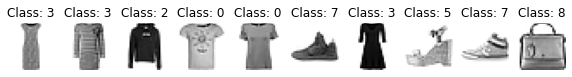

In [38]:
# 데이터 확인하기(2)
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.axis('off')
  plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
  plt.title('Class: '+str(y_train[i].item()))

In [49]:
# AutoEncoder(AE) 모델 설계
class AE(nn.Module):
  def __init__(self): # AE 클래스의 인스턴스를 생성했을 때 지니게 되는 성질을 정의해주는 메서드
    super(AE, self).__init__() # nn.Module 내에 있는 메서드를 상속받아 이용

    self.encoder=nn.Sequential( # nn.Sequential을 이용해 인코더 단위를 한 번에 정의
        nn.Linear(28*28, 512),
        nn.ReLU(), # 비선형함수를 적용해 두 번째 레이어의 input으로 전달
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 32),
    )
    
    self.decoder=nn.Sequential(
        nn.Linear(32, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 28*28),
    )

  def forward(self, x): # 설계한 AE의 인코더와 디코더에 데이터를 입력했을 때 output을 계산하기까지의 과정을 나열
    encoded=self.encoder(x)
    decoded=self.decoder(encoded)
    return encoded, decoded

In [50]:
# Optimizer, Objective Function 설정
model=AE().to(DEVICE)
optimizer=torch.optim.Adam(model.parameters(), lr=0.001) 
criterion=nn.MSELoss() # input으로 이루어진 이미지 데이터와 복원된 이미지 데이터 값 간의 MSE를 이용해 output을 계산하기 위해 사용

In [51]:
# AE 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, _) in enumerate(train_loader): # 레이블 데이터를 활용해 학습하는 것이 아니라 입력 데이터를 타깃으로 학습하기 때문에 레이블 데이터 이용할 필요 X
    image=image.view(-1, 28*28).to(DEVICE)
    target=image.view(-1, 28*28).to(DEVICE) # 원본과 같게 복원
    optimizer.zero_grad() # optimizer 초기화
    encoded, decoded=model(image)
    loss=criterion(decoded, target)
    loss.backward()
    optimizer.step()

    if batch_idx%log_interval==0:
      print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(Epoch, batch_idx*len(image), len(train_loader.dataset), 100.*batch_idx/len(train_loader), loss.item()))

In [52]:
# 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
  model.eval()
  test_loss=0
  real_image=[] # 학습 과정 속에서 AE에 이용되는 실제 이미지 데이터를 리스트에 저장
  gen_image=[] # 학습 과정 속에서 AE를 통해 생성되는 이미지 데이터를 리스트에 저장

  with torch.no_grad(): # 평가하는 단계에서 gradient를 통해 파라미터 값이 업데이트되는 현상을 방지하기 위해 gradient 흐름 억제
    for image, _ in test_loader:
      image=image.view(-1, 28*28).to(DEVICE)
      target=image.view(-1, 28*28).to(DEVICE)
      encoded, decoded=model(image)

      test_loss+=criterion(decoded, image).item()
      real_image.append(image.to("cpu"))
      gen_image.append(decoded.to("cpu"))
  
  test_loss/=len(test_loader.dataset)
  return test_loss, real_image, gen_image

Train Epoch: 1 [0/60000(0%)]	Train Loss: 0.011396
Train Epoch: 1 [6400/60000(11%)]	Train Loss: 0.009547
Train Epoch: 1 [12800/60000(21%)]	Train Loss: 0.009162
Train Epoch: 1 [19200/60000(32%)]	Train Loss: 0.010891
Train Epoch: 1 [25600/60000(43%)]	Train Loss: 0.011338
Train Epoch: 1 [32000/60000(53%)]	Train Loss: 0.009141
Train Epoch: 1 [38400/60000(64%)]	Train Loss: 0.009589
Train Epoch: 1 [44800/60000(75%)]	Train Loss: 0.011241
Train Epoch: 1 [51200/60000(85%)]	Train Loss: 0.011166
Train Epoch: 1 [57600/60000(96%)]	Train Loss: 0.011496

[EPOCH: 1], 	Test Loss: 0.0003


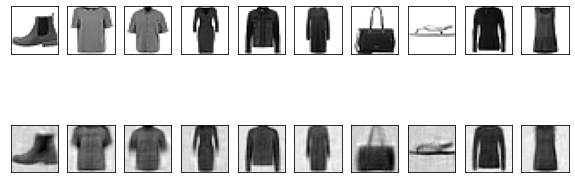

Train Epoch: 2 [0/60000(0%)]	Train Loss: 0.010991
Train Epoch: 2 [6400/60000(11%)]	Train Loss: 0.007117
Train Epoch: 2 [12800/60000(21%)]	Train Loss: 0.010522
Train Epoch: 2 [19200/60000(32%)]	Train Loss: 0.008672
Train Epoch: 2 [25600/60000(43%)]	Train Loss: 0.008948
Train Epoch: 2 [32000/60000(53%)]	Train Loss: 0.008059
Train Epoch: 2 [38400/60000(64%)]	Train Loss: 0.010143
Train Epoch: 2 [44800/60000(75%)]	Train Loss: 0.009077
Train Epoch: 2 [51200/60000(85%)]	Train Loss: 0.008935
Train Epoch: 2 [57600/60000(96%)]	Train Loss: 0.009024

[EPOCH: 2], 	Test Loss: 0.0003


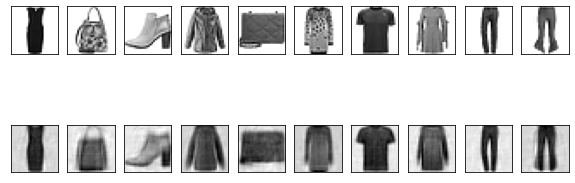

Train Epoch: 3 [0/60000(0%)]	Train Loss: 0.009874
Train Epoch: 3 [6400/60000(11%)]	Train Loss: 0.008473
Train Epoch: 3 [12800/60000(21%)]	Train Loss: 0.008553
Train Epoch: 3 [19200/60000(32%)]	Train Loss: 0.010847
Train Epoch: 3 [25600/60000(43%)]	Train Loss: 0.011667
Train Epoch: 3 [32000/60000(53%)]	Train Loss: 0.009646
Train Epoch: 3 [38400/60000(64%)]	Train Loss: 0.009814
Train Epoch: 3 [44800/60000(75%)]	Train Loss: 0.012184
Train Epoch: 3 [51200/60000(85%)]	Train Loss: 0.010158
Train Epoch: 3 [57600/60000(96%)]	Train Loss: 0.009365

[EPOCH: 3], 	Test Loss: 0.0003


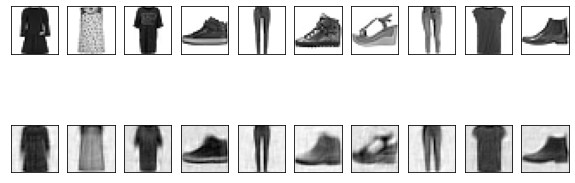

Train Epoch: 4 [0/60000(0%)]	Train Loss: 0.012646
Train Epoch: 4 [6400/60000(11%)]	Train Loss: 0.008805
Train Epoch: 4 [12800/60000(21%)]	Train Loss: 0.008464
Train Epoch: 4 [19200/60000(32%)]	Train Loss: 0.008176
Train Epoch: 4 [25600/60000(43%)]	Train Loss: 0.010235
Train Epoch: 4 [32000/60000(53%)]	Train Loss: 0.009318
Train Epoch: 4 [38400/60000(64%)]	Train Loss: 0.007914
Train Epoch: 4 [44800/60000(75%)]	Train Loss: 0.009980
Train Epoch: 4 [51200/60000(85%)]	Train Loss: 0.009330
Train Epoch: 4 [57600/60000(96%)]	Train Loss: 0.008892

[EPOCH: 4], 	Test Loss: 0.0003


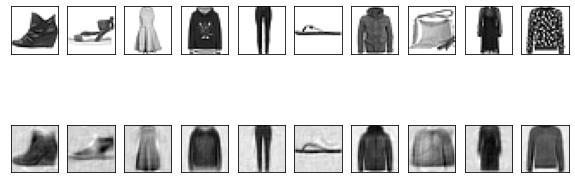

Train Epoch: 5 [0/60000(0%)]	Train Loss: 0.008548
Train Epoch: 5 [6400/60000(11%)]	Train Loss: 0.010618
Train Epoch: 5 [12800/60000(21%)]	Train Loss: 0.009842
Train Epoch: 5 [19200/60000(32%)]	Train Loss: 0.010204
Train Epoch: 5 [25600/60000(43%)]	Train Loss: 0.008328
Train Epoch: 5 [32000/60000(53%)]	Train Loss: 0.007978
Train Epoch: 5 [38400/60000(64%)]	Train Loss: 0.011331
Train Epoch: 5 [44800/60000(75%)]	Train Loss: 0.008018
Train Epoch: 5 [51200/60000(85%)]	Train Loss: 0.007855
Train Epoch: 5 [57600/60000(96%)]	Train Loss: 0.008747

[EPOCH: 5], 	Test Loss: 0.0003


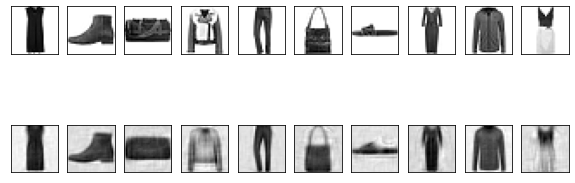

Train Epoch: 6 [0/60000(0%)]	Train Loss: 0.010606
Train Epoch: 6 [6400/60000(11%)]	Train Loss: 0.008639
Train Epoch: 6 [12800/60000(21%)]	Train Loss: 0.011744
Train Epoch: 6 [19200/60000(32%)]	Train Loss: 0.010116
Train Epoch: 6 [25600/60000(43%)]	Train Loss: 0.009491
Train Epoch: 6 [32000/60000(53%)]	Train Loss: 0.011827
Train Epoch: 6 [38400/60000(64%)]	Train Loss: 0.009816
Train Epoch: 6 [44800/60000(75%)]	Train Loss: 0.010119
Train Epoch: 6 [51200/60000(85%)]	Train Loss: 0.009756
Train Epoch: 6 [57600/60000(96%)]	Train Loss: 0.009525

[EPOCH: 6], 	Test Loss: 0.0003


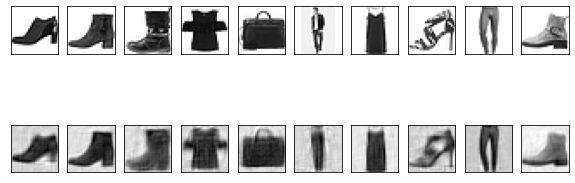

Train Epoch: 7 [0/60000(0%)]	Train Loss: 0.007721
Train Epoch: 7 [6400/60000(11%)]	Train Loss: 0.007635
Train Epoch: 7 [12800/60000(21%)]	Train Loss: 0.008756
Train Epoch: 7 [19200/60000(32%)]	Train Loss: 0.008010
Train Epoch: 7 [25600/60000(43%)]	Train Loss: 0.009615
Train Epoch: 7 [32000/60000(53%)]	Train Loss: 0.008343
Train Epoch: 7 [38400/60000(64%)]	Train Loss: 0.011139
Train Epoch: 7 [44800/60000(75%)]	Train Loss: 0.009305
Train Epoch: 7 [51200/60000(85%)]	Train Loss: 0.010328
Train Epoch: 7 [57600/60000(96%)]	Train Loss: 0.008447

[EPOCH: 7], 	Test Loss: 0.0003


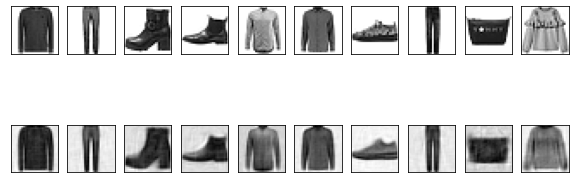

Train Epoch: 8 [0/60000(0%)]	Train Loss: 0.009407
Train Epoch: 8 [6400/60000(11%)]	Train Loss: 0.009163
Train Epoch: 8 [12800/60000(21%)]	Train Loss: 0.008172
Train Epoch: 8 [19200/60000(32%)]	Train Loss: 0.009603
Train Epoch: 8 [25600/60000(43%)]	Train Loss: 0.009658
Train Epoch: 8 [32000/60000(53%)]	Train Loss: 0.009843
Train Epoch: 8 [38400/60000(64%)]	Train Loss: 0.008754
Train Epoch: 8 [44800/60000(75%)]	Train Loss: 0.008878
Train Epoch: 8 [51200/60000(85%)]	Train Loss: 0.008057
Train Epoch: 8 [57600/60000(96%)]	Train Loss: 0.011146

[EPOCH: 8], 	Test Loss: 0.0003


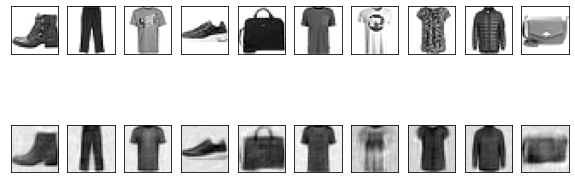

Train Epoch: 9 [0/60000(0%)]	Train Loss: 0.007894
Train Epoch: 9 [6400/60000(11%)]	Train Loss: 0.008001
Train Epoch: 9 [12800/60000(21%)]	Train Loss: 0.011138
Train Epoch: 9 [19200/60000(32%)]	Train Loss: 0.006896
Train Epoch: 9 [25600/60000(43%)]	Train Loss: 0.009512
Train Epoch: 9 [32000/60000(53%)]	Train Loss: 0.008948
Train Epoch: 9 [38400/60000(64%)]	Train Loss: 0.010156
Train Epoch: 9 [44800/60000(75%)]	Train Loss: 0.009734
Train Epoch: 9 [51200/60000(85%)]	Train Loss: 0.007848
Train Epoch: 9 [57600/60000(96%)]	Train Loss: 0.010541

[EPOCH: 9], 	Test Loss: 0.0003


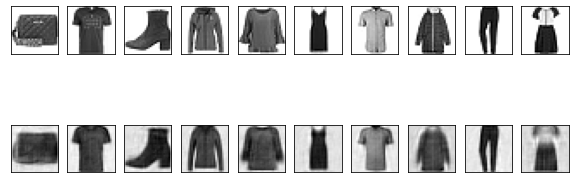

Train Epoch: 10 [0/60000(0%)]	Train Loss: 0.009020
Train Epoch: 10 [6400/60000(11%)]	Train Loss: 0.008803
Train Epoch: 10 [12800/60000(21%)]	Train Loss: 0.008603
Train Epoch: 10 [19200/60000(32%)]	Train Loss: 0.008496
Train Epoch: 10 [25600/60000(43%)]	Train Loss: 0.006505
Train Epoch: 10 [32000/60000(53%)]	Train Loss: 0.006988
Train Epoch: 10 [38400/60000(64%)]	Train Loss: 0.009454
Train Epoch: 10 [44800/60000(75%)]	Train Loss: 0.010290
Train Epoch: 10 [51200/60000(85%)]	Train Loss: 0.010343
Train Epoch: 10 [57600/60000(96%)]	Train Loss: 0.008160

[EPOCH: 10], 	Test Loss: 0.0003


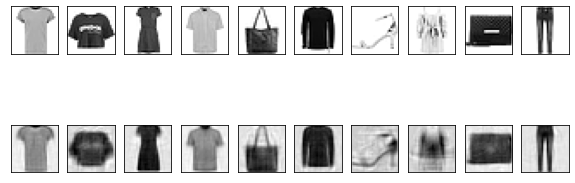

In [55]:
# AE 학습을 실행하면서 Test set의 Reconstruction Error 확인하기
for Epoch in range(1, EPOCHS+1):
  train(model, train_loader, optimizer, log_interval=200)
  test_loss, real_image, gen_image=evaluate(model, test_loader)
  print("\n[EPOCH: {}], \tTest Loss: {:.4f}".format(Epoch, test_loss))
  f, a = plt.subplots(2, 10, figsize=(10, 4))
  for i in range(10):
    img=np.reshape(real_image[0][i], (28,28))
    a[0][i].imshow(img, cmap="gray_r")
    a[0][i].set_xticks(())
    a[0][i].set_yticks(())

  for i in range(10):
    img=np.reshape(gen_image[0][i], (28,28))
    a[1][i].imshow(img, cmap="gray_r")
    a[1][i].set_xticks(())
    a[1][i].set_yticks(())

  plt.show()